In [2]:
%matplotlib inline
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import ipywidgets as widgets
import datetime
import seaborn as sns
import scipy
import statsmodels.api as sm
from ipywidgets import interact, interact_manual
import dateutil.parser
from tqdm.notebook import tqdm


In [3]:
# input
dir_eo = '../data/wps-reservoir-time-series-latest/time_series_area_raw/'

# output
dir_eo_monthly = '../data/wps-reservoir-time-series-latest/time_series_area_monthly/' 
dir_eo_raw = '../data/wps-reservoir-time-series-latest/time_series_area/' # raw time,area series only

In [4]:
pathlib.Path(dir_eo_monthly).mkdir(exist_ok=True)
pathlib.Path(dir_eo_raw).mkdir(exist_ok=True)

In [5]:
reservoirs_by_filenames = list(pathlib.Path(dir_eo).glob('*.geojson'))

In [6]:
# specific file only
# reservoirs_by_filenames = list(pathlib.Path(dir_eo).glob('0090567.geojson'))

In [243]:
def get_data(filename):
    ts = json.loads(open(dir_eo + filename).read())['features'][0]['properties']
    
    df = pd.DataFrame({ 
        'time': ts['water_area_time'], 'water_area_filled': ts['water_area_filled'], 'area': ts['water_area_filled'], 'mission': ts['mission'],
        'ndwi_threshold': ts['ndwi_threshold'], 'quality_score': ts['quality_score'], 
        'water_area_filled_fraction': ts['water_area_filled_fraction'], 
        'water_area_p': ts['water_area_p'], 'water_area_value': ts['water_area_value']
    })
    
    df['time_ms'] = df.time

    df.time = pd.to_datetime(df.time, unit='ms')
    df = df.set_index('time')
    
    df = df[df.water_area_filled_fraction < 0.4]
    
    return df

In [8]:
# remove large gradients
def remove_large_gradients(df, th):
    df['water_area_filled_grad'] = df.area.diff()
    df = df[pd.notnull(df.water_area_filled_grad)]

    if len(df.water_area_filled_grad.to_numpy()):
        grad_th = np.percentile(np.abs(df.water_area_filled_grad.to_numpy()), th)
        df = df[np.abs(df.water_area_filled_grad) < grad_th]

    return df


In [9]:
def clean_data_v1(df_eo):
    df_eo['area'] = df_eo.water_area_filled
    
    # round to days
    df_eo.index = df_eo.index.round('D')
    
#     df_eo = remove_large_gradients(df_eo, 75)
#     df_eo = remove_large_gradients(df_eo, 90)

#     df_eo = remove_large_gradients(df_eo, 85)
#     df_eo = remove_large_gradients(df_eo, 85)
    
    df_eo = remove_large_gradients(df_eo, 90)
    df_eo = remove_large_gradients(df_eo, 99)

    # take top 90% (eliminate underfilling due to lower trust in water occurrence)
#     df_eo = df_eo.resample('M').max() 
    df_eo = df_eo.resample('M').apply(lambda x: x.quantile(0.98))

    if len(df_eo) == 0:
        return df_eo
    
    # smoothen using akima
    df_eo = df_eo.interpolate(method='akima')
#     df_eo = df_eo.interpolate(method='barycentric')
    df_eo = df_eo.shift(-1)



#     df2 = df2.sort_index()
#     z = sm.nonparametric.lowess(df2.water_area_filled, df2.time_ms, return_sorted=False, frac=1/200)
#     df2['z'] = z
#     ax.plot(df2.index, df2.z, 'g-')

#     df3 = df2.resample('W').max().interpolate(method='polynomial', order=2)
#     df3 = df3.ewm(span = 3).mean()


#     df3 = df3.resample('3W').mean()
    
#     df3 = df3.shift(-1)
#     df3 = df2.resample('W').max().interpolate(method='linear')
#     df2 = df2.resample('D').interpolate(method='polynomial', order=2)
#     df2 = df2.resample('D').interpolate(method='akima')

#     df4 = df3.sort_index()
#     z = sm.nonparametric.lowess(df4.water_area_filled, df4.time_ms, return_sorted=False, frac=1/100)
#     df4['z'] = z
#     ax.plot(df4.index, df4.z, 'b-')
   
#     ax.plot(df2.index, df2.water_area_filled, 'b-')
 

    return df_eo

In [10]:
def clean_data(df_eo, step='M', skip_missings=True, min_missings_step=12):
    d = df_eo
    d['area'] = d.water_area_filled
    d = d[['area']]

    # round to days
    d.index = d.index.round('D')

#     d = remove_large_gradients(d, 90)
#     d = remove_large_gradients(d, 99)

    # take top 90% (eliminate underfilling due to lower trust in water occurrence)
    d = d.resample(step).apply(lambda x: x.quantile(0.90))

    # create mask
    if skip_missings:
        mask = d.copy()
        grp = ((mask.notnull() != mask.shift().notnull()).cumsum())
        grp['ones'] = 1
        mask['area'] = (grp.groupby('area')['ones'].transform('count') < min_missings_step) | d['area'].notnull()

    # smoothen
    d = d.interpolate(method='pchip')
    # d = d.shift(-1)

    # apply missing values mask (>6 months)
    if skip_missings:
        d[mask.area == False] = None

    return d

In [244]:
def plot(filename):
    df = get_data(filename)

#     date_start = '2000-01-01'
#     date_stop = '2018-08-01'
#     df = df[df.index > dateutil.parser.parse(date_start)]

    fig, ax = plt.subplots(figsize=(20, 7))
    
#     ax.plot(df.index, df.water_area_value, 'r.', alpha=0.3)
#     ax.plot(df.index, df.water_area_filled, 'g.')
#     ax.set_xlim([dateutil.parser.parse(date_start), dateutil.parser.parse(date_stop)])    
    
    df_clean = clean_data(df)

    # plot original points
    ax.plot(df.index, df.area, 'r.', alpha = 0.9, markersize=2)

    # plot interpolated smoothed, converted to equidistant time scale
    ax.plot(df_clean.index, df_clean.area, 'k-')
    
#     ax.plot(df_monthly.time, df_monthly.area, 'k-')
#     ax.scatter(df_raw.time, df_raw.area, s=2, alpha=0.9, color='red')    
    plt.grid(axis='both')
    
    plt.show()
    
    return df

    

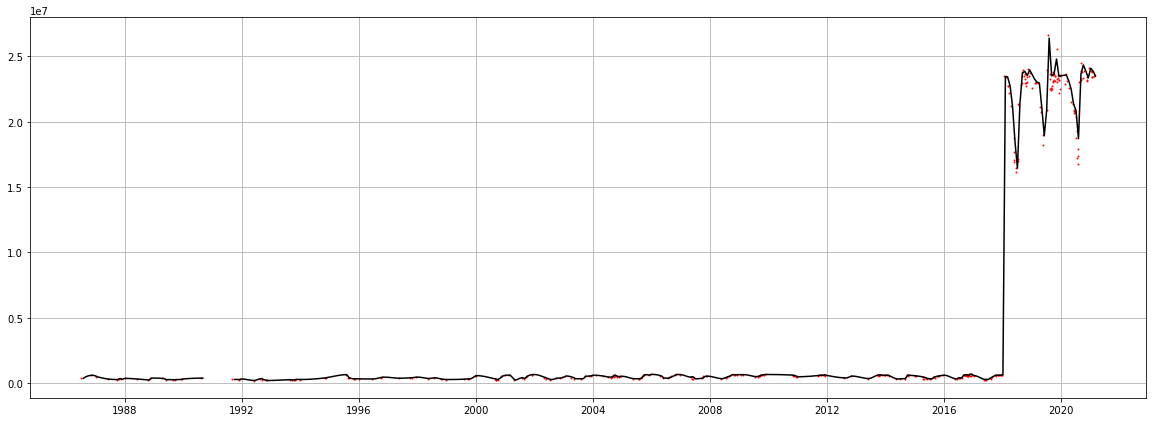

In [169]:
de = plot('0086911.geojson')

In [30]:
import tqdm.notebook

In [31]:
# export all

start_index = 0

for f in tqdm.notebook.tqdm(list(reservoirs_by_filenames)[start_index:]):
    df = get_data(f.name)

    if(not df.size):
        print('Empty, ' + str(f) + ' skipping ...')
        continue
    df = clean_data(df)
    
    df.loc[df.area < 0, 'area'] = 0
    
    df[['area']].dropna().to_csv(dir_eo_monthly + str(f.name).split('.')[0] + '.csv')

In [32]:
# export raw
for f in tqdm.notebook.tqdm(reservoirs_by_filenames):
    df = json.loads(open(dir_eo + f.name).read())['features'][0]['properties']
    df = pd.DataFrame({ 'time': df['water_area_time'], 'area': df['water_area_filled'] })
    df.time = pd.to_datetime(df.time, unit='ms')
    df.index = df.time
    
    if(not df.size): 
        print('Empty, ' + str(f) + ' skipping ...')
        continue
        
    df[['area']].to_csv(dir_eo_raw + f.name.split('.')[0] + '.csv', date_format='%Y-%m-%d %H:%M')

In [ ]:
# export daily and monthly with ms timestamps

In [33]:
path = pathlib.Path(dir_eo_raw)
dir_eo_raw_ms = path.parent / f'{path.name}-ms'
dir_eo_raw_ms.mkdir(exist_ok=True)

path = pathlib.Path(dir_eo_monthly)
dir_eo_monthly_ms = path.parent / f'{path.name}-ms'
dir_eo_monthly_ms.mkdir(exist_ok=True)

In [22]:
t_epoch = np.datetime64('1970-01-01T00:00:00')
sec = np.timedelta64(1, 's')

In [31]:
# convert raw (datetime, area) => (timestamp, area)
for path in tqdm(reservoirs_by_filenames):
    path_in = pathlib.Path(dir_eo_raw) / f'{path.stem}.csv'
    path_out = dir_eo_raw_ms / f'{path.stem}.parquet'

    if not os.path.exists(path_in):
        continue

#     if os.path.exists(path_out):
#         continue
        
    df = pd.read_csv(path_in)
    df['time']= df.time.apply(lambda t: int((np.datetime64(t) - t_epoch) / sec))

    df.to_parquet(path_out, index=False)


In [34]:
# convert raw (datetime, area) => (timestamp, area)
for path in tqdm(reservoirs_by_filenames):
    path_in = pathlib.Path(dir_eo_monthly) / f'{path.stem}.csv'
    path_out = dir_eo_monthly_ms / f'{path.stem}.parquet'
    
    if not os.path.exists(path_in):
        continue
    
    df = pd.read_csv(path_in)
    df['time']= df.time.apply(lambda t: int((np.datetime64(t) - t_epoch) / sec))
    
    df.to_parquet(path_out, index=False)


In [245]:
def detect_jump_2019(filename):
    df = get_data(filename)

#     date_start = '2000-01-01'
#     date_stop = '2018-08-01'
#     df = df[df.index > dateutil.parser.parse(date_start)]

    date_start = '2017-01-01'
    date_middle = '2018-01-01'
    date_end = '2019-01-01'
    
    a1 = df[(df.index > dateutil.parser.parse(date_start)) & (df.index < dateutil.parser.parse(date_middle))].water_area_filled.mean()
    a2 = df[(df.index > dateutil.parser.parse(date_middle)) & (df.index < dateutil.parser.parse(date_end))].water_area_filled.mean()
    a3 = df[(df.index > dateutil.parser.parse(date_start)) & (df.index < dateutil.parser.parse(date_end))].water_area_filled.mean()
    
    return [a1 / a3, a2 / a3]


In [235]:
ratios_before = []
ratios_after = []
ratios = []
for f in tqdm(reservoirs_by_filenames):
    r1, r2 = detect_jump_2019(f.name)
    ratios.append(min(r1, r2) / max(r1, r2))
    ratios_before.append(r1)
    ratios_after.append(r2)

In [250]:
def plot_ts(filename):
    path = pathlib.Path(dir_eo_monthly) / (filename + '.csv')
    df = pd.read_csv(path)
    df.time = pd.to_datetime(df.time)

    fig, ax = plt.subplots(figsize=(20, 7))
#     ax.plot(df.time, df.area, 'k.')
    ax.plot(df.time, df.area, 'k-', linewidth=0.5)

    path = pathlib.Path(dir_eo_raw) / (filename + '.csv')
    df = pd.read_csv(path)
    df.time = pd.to_datetime(df.time)

    ax.plot(df.time, df.area, 'b.', markersize=2)
    
    plt.grid(axis='both')
    plt.show()
        

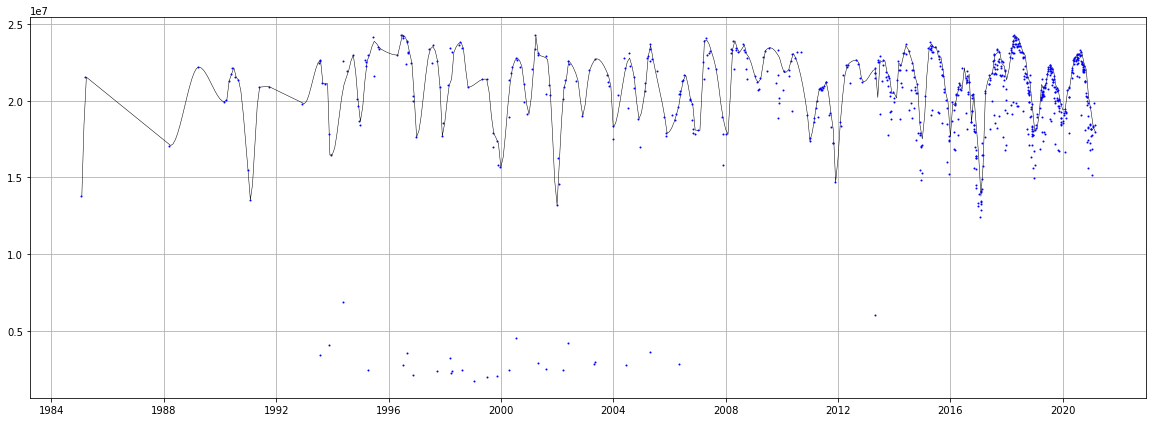

In [251]:
plot_ts(f'{str(87235).zfill(7)}')

In [253]:
indices = np.where(np.array(ratios) < 0.05)[0]
print(len(indices))

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(i=widgets.IntSlider(min=0, max=len(indices)-1, step=1))
def show(i):
    print(reservoirs_by_filenames[indices[i]])
    r1, r2 = detect_jump_2019(reservoirs_by_filenames[indices[i]].name)
    print(min(r1, r2) / max(r1, r2))
    plot_ts(reservoirs_by_filenames[indices[i]].stem)

79


interactive(children=(IntSlider(value=0, description='i', max=78), Output()), _dom_classes=('widget-interact',…

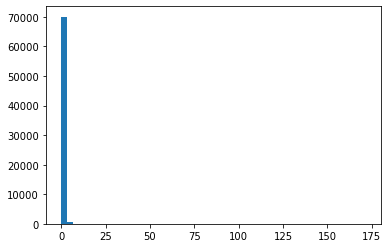

In [83]:
_ = plt.hist(ratios, bins=50)

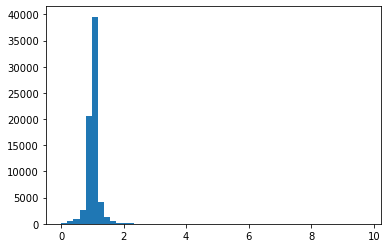

In [37]:
_ = plt.hist(ratios_before, bins=50)

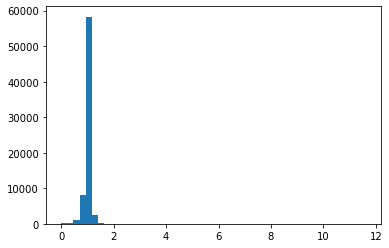

In [38]:
_ = plt.hist(ratios_after, bins=50)